In [1]:
import tensorflow as tf
import numpy as np
import math
from sensei.loss import Loss

import tensorflow_addons as tfa
from milani_fpn import Milani2_FPNlstm

from processor_fpn import VerdePreprocessor, BasicPostprocessor

from meta import *


class SparseSoftmaxCrossEntropyRegularizesLoss(tf.keras.Model):
    def __init__(self, superblocks = 0, name="SparseSoftmaxCrossEntropyRegularizesLoss", logits_key=None, no_reduce=False, **kwargs):#**kwargs):

        super(SparseSoftmaxCrossEntropyRegularizesLoss, self).__init__(**kwargs)
        self.superblocks = superblocks
        self.nam = name
        self.logits_key = logits_key
        self.no_reduce = no_reduce

    @tf.function
    def __call__(self, y_true, y_pred, sample_weight=None):
        # print(y_true, y_pred)
        if self.logits_key != None:
            y_pred = y_pred[self.logits_key]
        if self.superblocks > 0:
            if self.superblocks == 1:
                y_pred = tf.reshape(y_pred, [-1, 2])
                y_true = tf.reduce_mean(y_true, axis=1)
            else:
                # y_pred = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1, 2])
                y_pred = tf.reshape(y_pred, [-1, 2])
                y_true = tf.reshape(y_true, [-1])
                # y_true = tf.expand_dims(y_true, axis=-1)
        else:
            y_true = tf.reshape(y_true, [-1])

        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred, name=self.nam)
        if self.no_reduce == True:
            # loss = tf.reduce_mean(loss, axis=[1], name='mean_entropy')
            pass
        else:
            loss = tf.reduce_mean(loss, axis=[0] if self.superblocks > 1 else [0], name='mean_entropy')
        # loss = tf.reduce_mean(loss, axis=[0,1] if self.superblocks > 1 else [0], name='mean_entropy')
        return loss

class SSCELoss(tf.keras.Model):
    def __init__(self, name="SSCELoss", **kwargs):#**kwargs):

        super(SSCELoss, self).__init__(**kwargs)
        self.nam = name

    @tf.function
    def __call__(self, y_true, y_pred, sample_weight=None):
        # y_true = tf.reshape(y_true, tf.shape(y_pred))
        # eye = tf.eye(2)
        # y_true = eye[y_true]

        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred, name=self.nam)
        return tf.reduce_mean(loss, [0])

    
class SparseSmoothSoftmaxCrossEntropyRegularizesLoss(tf.keras.Model):
    def __init__(self, superblocks = 0, name="SparseSmoothSoftmaxCrossEntropyRegularizesLoss", 
                 logits_key=None, no_reduce=False, smooth = 0.1, **kwargs):#**kwargs):

        super(SparseSmoothSoftmaxCrossEntropyRegularizesLoss, self).__init__(**kwargs)
        self.superblocks = superblocks
        self.nam = name
        self.logits_key = logits_key
        self.no_reduce = no_reduce
        self.smoothing = smooth
        self.loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True,
                                                                 label_smoothing=smooth,
                                                                 name='categorical_crossentropy_smooth')

    @tf.function
    def __call__(self, y_true, y_pred, sample_weight=None):
        # print(y_true, y_pred)
        y_true = tf.reshape(y_true,[-1,1])
        y_true = tf.concat([1-y_true,y_true])
            
        if self.logits_key != None:
            y_pred = y_pred[self.logits_key]
        if self.superblocks > 0:
            if self.superblocks == 1:
                y_pred = tf.reshape(y_pred, [-1, 2])
                y_true = tf.reduce_mean(y_true, axis=1)
            else:
                # y_pred = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1, 2])
                y_pred = tf.reshape(y_pred, [-1, 2])
                y_true = tf.reshape(y_true, [-1, 2])
                # y_true = tf.expand_dims(y_true, axis=-1)
        else:
            y_true = tf.reshape(y_true, [-1,2])

        loss = self.loss_func(labels=y_true, logits=y_pred)
        if self.no_reduce == True:
            # loss = tf.reduce_mean(loss, axis=[1], name='mean_entropy')
            pass
        else:
            loss = tf.reduce_mean(loss, axis=[0] if self.superblocks > 1 else [0], name='mean_entropy')
        # loss = tf.reduce_mean(loss, axis=[0,1] if self.superblocks > 1 else [0], name='mean_entropy')
        return loss    

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
##@tf.function
def grid_im(images, h=32,w=32):
        img_shape = tf.shape(images)
        s = [img_shape[0]//h,img_shape[1]//w, img_shape[2]]
        images =  tf.reshape(images, [1,img_shape[0],img_shape[1],3])
        patches = tf.image.extract_patches(images=images,
                                           sizes=[1, h, w, 1],
                                           strides=[1, h, w, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        print(patches.shape)
        patches = tf.reshape(patches,[-1,h*w*3])
        ind = np.arange(patches.shape[0])
        np.random.shuffle(ind) 
        list_p =[]
        for i in ind.tolist():
            list_p += [patches[i:i+1,:]]
            print(patches[i:i+1,:].shape, i)
        #print(patches[ind.tolist(),:].shape)
        patches1 = tf.concat(list_p,axis=0)#tf.gather(patches, ind.tolist(), axis=0)
        return tf.reshape(patches1, ( 1,s[0],s[1],w*h*img_shape[2]))
##@tf.function
def inverse_patches(images, n=32):
            img_shape = tf.shape(images)
            #with tf.GradientTape() as tape:
            patches = grid_im(images, h=n,w=n)
        
            print(patches.shape,img_shape)
               
        
            _x = tf.zeros(img_shape)
            _y = grid_im(_x, h=n, w=n)
    
            grad = tf.gradients(_y, _x)[0]
            return tf.gradients(_y, _x, grad_ys=patches)[0] / grad

In [3]:
import scipy.misc

face = scipy.misc.face()

In [4]:
import matplotlib.pyplot as plt

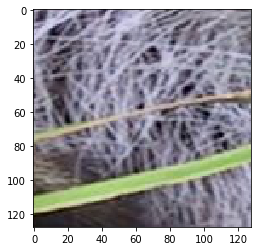

In [5]:
N100 = 350
face = face[N100:128+N100,N100:128+N100,:]
plt.imshow(face)
plt.show()

In [6]:
train_preprocessor = VerdePreprocessor(img_size=IMAGE_SIZE, pipeline=0, keep_scales=False, onehot=False, onehot_classes=2, augmentation_config=None, use_resize=False, just_read=False, encode=False, mode=1 , patch_aug=1)



In [8]:
x_true = tf.reshape(tf.cast(face, dtype=tf.float32)/225., [128,128,3])
y_true = tf.ones([1])

(1, 4, 4, 3072)
(1, 3072) 4
(1, 3072) 3
(1, 3072) 9
(1, 3072) 12
(1, 3072) 5
(1, 3072) 2
(1, 3072) 6
(1, 3072) 7
(1, 3072) 0
(1, 3072) 15
(1, 3072) 8
(1, 3072) 11
(1, 3072) 14
(1, 3072) 13
(1, 3072) 10
(1, 3072) 1


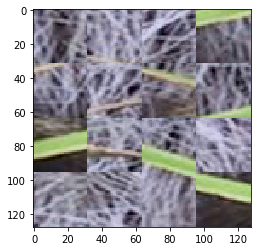

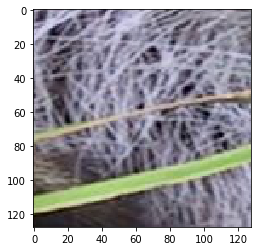

In [52]:
I = grid_im(face,32,32)
I = tf.reshape(I,[1,4,4,32,32,3])
I_0 = tf.squeeze(tf.concat([tf.image.random_flip_left_right(I[0,i,0,:,:,:]) for i in [0,1,2,3]], axis=1))
I_1 = tf.squeeze(tf.concat([tf.image.random_flip_left_right(I[0,i,1,:,:,:]) for i in [0,1,2,3]], axis=1))
I_2 = tf.squeeze(tf.concat([tf.image.random_flip_left_right(I[0,i,2,:,:,:]) for i in [0,1,2,3]], axis=1))
I_3 = tf.squeeze(tf.concat([tf.image.random_flip_left_right(I[0,i,3,:,:,:]) for i in [0,1,2,3]], axis=1))
I_ = tf.squeeze(tf.concat([I_0,I_2,I_3,I_1], axis=0))
plt.imshow(I_)
plt.show()
plt.imshow(face)
plt.show()

input data: (128, 128, 3)
(1, 4, 4, 3072)
(1, 3072) 6
(1, 3072) 14
(1, 3072) 11
(1, 3072) 12
(1, 3072) 1
(1, 3072) 8
(1, 3072) 13
(1, 3072) 5
(1, 3072) 7
(1, 3072) 9
(1, 3072) 10
(1, 3072) 2
(1, 3072) 0
(1, 3072) 4
(1, 3072) 15
(1, 3072) 3
patches: (128, 128, 3)
augment data: (128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


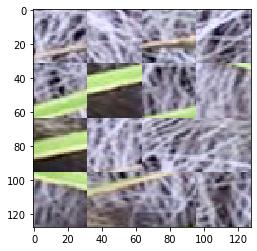

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


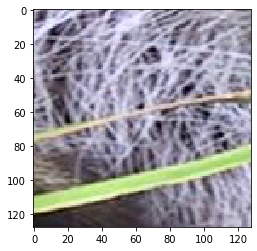

In [9]:
I = train_preprocessor.preprocess(x_true,y_true)
plt.imshow(I[0])
plt.show()
plt.imshow(x_true)
plt.show()

In [ ]:
train_loss = SparseSmoothSoftmaxCrossEntropyRegularizesLoss(superblocks=5, logits_key="logits")
val_loss = SparseSmoothSoftmaxCrossEntropyRegularizesLoss(superblocks=5, logits_key="logits", no_reduce=True)

In [6]:
y_true = tf.ones([10,5,2])

y_true = tf.ones(10,)

In [7]:
y_true=tf.ones(10)

In [8]:

y_true=tf.reshape(y_true,[-1,1])
y_true = tf.concat([1-y_true,y_true], axis = -1)
y_true.shape

TensorShape([10, 2])

In [9]:
y_true = tf.ones([10,5,1])

In [10]:
tf.concat([y_true,1-y_true],axis=2)

<tf.Tensor: shape=(10, 5, 2), dtype=float32, numpy=
array([[[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]], dtype=float32)>

In [4]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1,  self.patch_size, self.patch_size, 3])
        return patches    
    
class Milani2_FPNlstm(tf.keras.Model):
    def __init__(self, resolution, dropout, num_features, classes, constructing_pipeline=False, mode=0, av_max=0, n1=3,k_n=1, patch_aug  = 0,pass_features=False, **kwargs):
        super(Milani2_FPNlstm, self).__init__(**kwargs)

        self.l2_scale = 0.02
        self.pass_features = pass_features
        self.patch_aug = patch_aug
        
        self.conv0 = tf.keras.layers.Conv2D(filters=4*k_n, kernel_size=(3, 3), strides=(1, 1), padding="SAME", activation=None, kernel_initializer=tf.keras.initializers.glorot_normal(), name='conv0')
        self.bn0 = tf.keras.layers.BatchNormalization(name='bn_0')
        self.relu0 = tf.keras.layers.ReLU()
        self.mp0 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))

        
        self.conv1 = tf.keras.layers.Conv2D(filters=k_n*8, kernel_size=(3, 3), strides=(1, 1), padding="SAME", activation=None, kernel_initializer=tf.keras.initializers.glorot_normal(), name='conv1')
        self.bn1 = tf.keras.layers.BatchNormalization(name='bn_1')
        self.relu1 = tf.keras.layers.ReLU()
        self.mp1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))        
        
        self.conv2 = tf.keras.layers.Conv2D(filters=k_n*12, kernel_size=(3, 3), strides=(1, 1), padding="SAME", activation=None, kernel_initializer=tf.keras.initializers.glorot_normal(), name='conv2')
        self.bn2 = tf.keras.layers.BatchNormalization(name='bn_2')
        self.relu2 = tf.keras.layers.ReLU()
        self.mp2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
    

        self.conv3 = tf.keras.layers.Conv2D(filters=k_n*16, kernel_size=(3, 3), strides=(1, 1), padding="SAME", activation=None, kernel_initializer=tf.keras.initializers.glorot_normal(), name='conv3')
        self.bn3 = tf.keras.layers.BatchNormalization(name='bn_3')
        self.relu3 = tf.keras.layers.ReLU()
        self.mp3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))

        
        self.conv4 = tf.keras.layers.Conv2D(filters=k_n*16, kernel_size=(3, 3), strides=(1, 1), padding="SAME", activation=None, kernel_initializer=tf.keras.initializers.glorot_normal(), name='conv4')
        self.bn4 = tf.keras.layers.BatchNormalization(name='bn_4')
        self.relu4 = tf.keras.layers.ReLU()
        self.mp4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))

                
        self.conv5 = tf.keras.layers.Conv2D(filters=k_n*32, kernel_size=(3, 3), strides=(1, 1), padding="SAME", activation=None, kernel_initializer=tf.keras.initializers.glorot_normal(), name='conv5')
        self.bn5 = tf.keras.layers.BatchNormalization(name='bn_5')
        self.relu5 = tf.keras.layers.ReLU()
        self.mp5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))


        
        self.conv6 = tf.keras.layers.Conv2D(filters=k_n*64, kernel_size=(3, 3), strides=(1, 1), padding="SAME", activation=None, kernel_initializer=tf.keras.initializers.glorot_normal(), name='conv6')
        self.bn6 = tf.keras.layers.BatchNormalization(name='bn_6')
        self.relu6 = tf.keras.layers.ReLU()
        self.mp6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))

 
        self.patch = Patches(16)
        self.lstm1 = tf.keras.layers.ConvLSTM2D(filters=k_n*2, kernel_size=(3,3), strides=(1, 1), padding='same', stateful = False, return_sequences= True)
        self.lstm2 = tf.keras.layers.ConvLSTM2D(filters=k_n*2, kernel_size=(3,3), strides=(1, 1), padding='same', return_sequences= False)
        self.convlstm = tf.keras.layers.Conv2D(filters=k_n, kernel_size=(3, 3), strides=(1, 1), padding="SAME", activation=None, kernel_initializer=tf.keras.initializers.glorot_normal(), name='convlstm')
        self.bnlstm = tf.keras.layers.BatchNormalization(name='bn_lstm')
        self.relulstm = tf.keras.layers.ReLU()        
        
        self.dn0 = tf.keras.layers.Dense(units=k_n*16, activation=None, kernel_initializer=tf.keras.initializers.glorot_uniform())
        self.dropout = tf.keras.layers.Dropout(0.5, name="dropout")
        self.dn1 = tf.keras.layers.Dense(units=2, activation=None, kernel_initializer=tf.keras.initializers.glorot_uniform())

        self.flat = tf.keras.layers.Flatten(name="features")
       
        self.resolution = resolution
        self.constructing = constructing_pipeline
        self.mode = mode
        
    #@tf.function
    def gaussian_blur(self, img, kernel_size=11, sigma=5):
        def gauss_kernel(channels, kernel_size, sigma):
            ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
            xx, yy = tf.meshgrid(ax, ax)
            kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
            kernel = kernel / tf.reduce_sum(kernel)
            kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
            return kernel

        gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
        gaussian_kernel = gaussian_kernel[..., tf.newaxis]

        return tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1], padding='SAME', data_format='NHWC')

    #@tf.function
    def highpass(self, images, kernel_size=11, sigma=5):
        blurred = self.gaussian_blur(images, kernel_size, sigma)
        subtracted = images - blurred

        return subtracted, images, blurred

    # @tf.function
    # def highpass_median(images, kernel_size=11, sigma=5):
    #     blurred = tfa.image.median_filter2d(image=images)#gaussian_blur(images, kernel_size, sigma)
    #     subtracted = images - blurred
    #
    #     return subtracted, images, blurred

    #@tf.function
    def mean_filter2d(self, image, filter_shape=(3, 3), name=None):
        with tf.name_scope(name or "mean_filter2d"):
            image = tf.convert_to_tensor(image, name="image")

            rank = image.shape.rank
            if rank != 3 and rank != 4:
                raise ValueError("image should be either 3 or 4-dimensional.")

            # Expand to a 4-D tensor
            if rank == 3:
                image = tf.expand_dims(image, axis=0)

            area = filter_shape[0] * filter_shape[1]
            filter_shape = filter_shape + (tf.shape(image)[-1], 1)
            kernel = tf.ones(shape=filter_shape, dtype=image.dtype) / area

            output = tf.nn.depthwise_conv2d(
                image, kernel, strides=(1, 1, 1, 1), padding="SAME")

            if rank == 3:
                output = tf.squeeze(output, axis=0)

            return output

    #@tf.function
    def highpass_median(self, images, kernel_size=11, sigma=5):
        blurred = self.mean_filter2d(image=images)  # tf.map_fn(lambda x: median_filter(data=x), images)#tfa.image.median_filter2d(image=images)  # gaussian_blur(images, kernel_size, sigma)
        subtracted = images - blurred

        return subtracted, images, blurred



    def resize_to(self, image, sz, keep_scales=False):
        if keep_scales == False:
            return tf.image.resize(images=image, size=(sz, sz))
        else:
            return tf.image.resize_with_pad(image=image, target_height=sz, target_width=sz)

    def resize_filter(self, images, scale=1.0/2.0):
        newsize = int(self.resolution * scale)
        # tf.print(newsize)
        rimages = self.resize_to(image=images, sz=newsize, keep_scales=False)
        r2images = self.resize_to(image=rimages, sz=self.resolution, keep_scales=False)
        noise = images - r2images

        return noise
 
    def patch_nn(self,x,n=8):
        print('patch_nn', tf.rank(x))

        #assert tf.shape(x)[0]>0, "unsupported strides"
        
        rank = x.shape.rank
        print(':::',rank==4,  tf.math.greater(rank , 3))
        
        x = tf.cond( rank==4 ,lambda: x,
                    lambda: tf.reshape(x,[1,tf.shape(x)[0],tf.shape(x)[1],tf.shape(x)[2]]))
        s = tf.shape(x)
        h = s[1] // n
        w = s[2] // n
        print(x.shape, h,w)
        # To create the batch information
        x = tf.cond((h>0)&(w>0), 
                    lambda:  tf.reshape(tf.image.extract_patches(images=x,sizes=[1, h, w, 1], strides=[1, h, w, 1], 
                                                                   rates=[1, 1, 1, 1],padding='SAME'),
                                          [s[0],-1,h,w,s[3]]), 
                    lambda: tf.reshape(x,[s[0],-1,s[1],s[2],s[3]]))
        print(tf.shape(x))
        return x                                      
            
    
    #@tf.function
    def call(self, inputs, training):

        x = inputs
        #tf.print('":"',tf.shape(x))
        original_shape = tf.shape(x)
        x = tf.reshape(x, [-1, self.resolution, self.resolution, 3])

        if self.mode == 0:
                #print(x.shape)
                #x, x_o, x_b = self.highpass_median(x)
                #x, x_o, x_b = self.jpeg_dif( x, n_jpg=2,q=95, q_Im=10.)
                x, x_o, x_b = self.highpass_median(x)
                
        x_in = x
        x_lstm = self.patch(x_in) 
        print(x_lstm.shape)
        if self.mode == 0:
            x_lstm = self.lstm1(x_lstm)
            print(x_lstm.shape)
            x_lstm = self.lstm2(x_lstm)
            print(x_lstm.shape)
            x_lstm = self.convlstm(x_lstm)
            x_lstm = self.bnlstm(x_lstm, training)
            x_lstm = self.relulstm(x_lstm)            
                                             
                                             
            x = self.conv0(x_in)
            x = self.bn0(x, training)
            x = self.relu0(x)
            x0 = x
            x = self.mp0(x)
            
            x = self.conv1(x)
            x = self.bn1(x, training)
            x = self.relu1(x)
            x1 = x
            x = self.mp1(x)
            
            x = self.conv2(x)
            x = self.bn2(x, training)
            x = self.relu2(x)
            x2 = x
            x = self.mp2(x)
            
            x = self.conv3(x)
            x = self.bn3(x, training)
            x = self.relu3(x)
            x3 = x
            
            x = tf.keras.layers.concatenate([x_lstm,x])
            x = self.mp3(x)
            
            x = self.conv4(x)
            x = self.bn4(x, training)
            x = self.relu4(x)
            x4 = x
            x = self.mp4(x)

            x = self.conv5(x)
            x = self.bn5(x, training)
            x = self.relu5(x)
            x5 = x
            x = self.mp5(x)
            
            x = self.conv6(x)
            x = self.bn6(x, training)
            x = self.relu6(x)
            x6 = x
            x = self.mp6(x)
            
            x7 = x
            
            
            
            x = self.flat(x)
            
            f = x
            x = self.dn0(x)
            x = self.dropout(x, training)
            x = self.dn1(x)

            logits = x
            if training == False:
                logits = tf.reshape(logits, [original_shape[0], -1, 2])

        if self.pass_features == True:
            return {"logits": logits, "logits_softmax": tf.nn.softmax(logits), "features": f}
        return {"logits": logits, "logits_softmax": tf.nn.softmax(logits)}#, "embeddings": f, "features": f}



In [5]:
del model

NameError: name 'model' is not defined

In [6]:
model = Milani2_FPNlstm(128,0.1,256,2, mode=0)
model.compile(loss = 'mse',metrics=['accuracy'])
model.fit(tf.ones((3,128,128,3)),tf.ones((3,)), epochs= 1,callbacks=[])

(None, None, 16, 16, 3)
(None, None, 16, 16, 2)
(None, 16, 16, 2)
(None, None, 16, 16, 3)
(None, None, 16, 16, 2)
(None, 16, 16, 2)


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node milani2_fp_nlstm/conv0/Conv2D (defined at <ipython-input-4-7a9195ef6665>:215) ]] [Op:__inference_train_function_8829]

Errors may have originated from an input operation.
Input Source operations connected to node milani2_fp_nlstm/conv0/Conv2D:
 milani2_fp_nlstm/sub (defined at <ipython-input-4-7a9195ef6665>:143)

Function call stack:
train_function


In [ ]:
inputs = np.random.random([3,5, 128,128, 3]).astype(np.float32)

lstm = tf.keras.layers.ConvLSTM2D(8,3,1)

c_0 = tf.convert_to_tensor(np.random.random([1, 8]).astype(np.float32))
h_0 = tf.convert_to_tensor(np.random.random([1, 8]).astype(np.float32))

outputs = lstm(inputs, initial_state=[h_0, c_0])
outputs

In [ ]:
model(tf.ones((3,128,128,3)))